In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/11 19:02:19 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.21.217.31 instead (on interface eth0)
22/09/11 19:02:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 19:02:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")

In [3]:
merchantdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchantdf = merchantdf.withColumnRenamed("name","company_name")

# Replace all square brackets with round brackets
merchantdf = merchantdf.withColumn('tags', regexp_replace('tags', '\\[', '\\('))
merchantdf = merchantdf.withColumn('tags', regexp_replace('tags', '\\]', '\\)'))

# Extract take rate into seperate column
merchantdf = merchantdf.withColumn("take_rate", 
                                   split(col("tags"), "\\),").getItem(2))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', 'take rate: ', 
                                                  ''))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', '\\(', ''))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', '\\)', ''))

# Extract revenue band
merchantdf = merchantdf.withColumn("revenue_band", 
                                   split(col("tags"), "\\),").getItem(1))\
                       .withColumn('revenue_band', 
                                   regexp_replace('revenue_band', '\\(', ''))\
                       .withColumn('revenue_band', 
                                   regexp_replace('revenue_band', '\\)', ''))

# Extract tags band
merchantdf = merchantdf.withColumn("tags", 
                                   split(col("tags"), "\\),").getItem(0))\
                       .withColumn('tags', 
                                   regexp_replace('tags', '\\(', ''))\
                       .withColumn('tags', 
                                   regexp_replace('tags', '\\)', ''))\
                       .withColumn('tags', 
                                   regexp_replace('tags', ' +', ' '))\
                       .withColumn('tags', 
                                   lower('tags'))

merchantdf.show(truncate=False)

+------------------------------------+-------------------------------------------------------------------------------------+------------+---------+------------+
|company_name                        |tags                                                                                 |merchant_abn|take_rate|revenue_band|
+------------------------------------+-------------------------------------------------------------------------------------+------------+---------+------------+
|Felis Limited                       |furniture, home furnishings and equipment shops, and manufacturers, except appliances|10023283211 | 0.18    | e          |
|Arcu Ac Orci Corporation            |cable, satellite, and other pay television and radio services                        |10142254217 | 4.22    | b          |
|Nunc Sed Company                    |jewelry, watch, clock, and silverware shops                                          |10165489824 | 4.40    | b          |
|Ultricies Dignissim Lacus Foundat

In [4]:
transactiondf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
transactiondf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")
transactiondf = transactiondf1.union(transactiondf2)
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")

## Revenue Band

  revenue_band  count
0            a   1602
1            b   1351
2            c    922
3            d     98
4            e     53


  revenue_band    count
0            a  3509188
1            b  2251496
2            c  1909472
3            d    78521
4            e    69053


<AxesSubplot:title={'center':'Distribution of Merchant Revenue Bands'}, ylabel='count'>

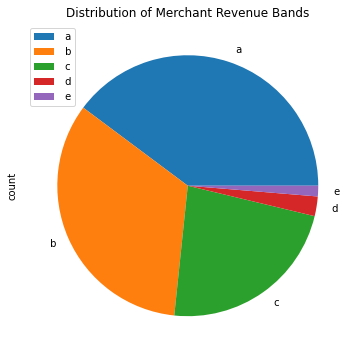

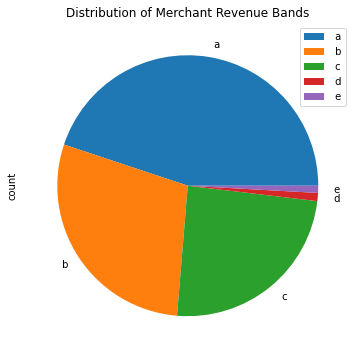

In [5]:
## Revenue Band
print(merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

## Now do all transactions have valid revenue bands?
print(sdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
sdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

Even after splitting from the tags field, we do not see any invalid entries in the revenue band field. The majority of revenue bands lie between a-c, with d and e revenue bands clearly being reserved for the most extreme merchants. Overall the number of merchants decreases as you reach a higher and higher revenue bands.

## Take Rate

           count
take_rate       
5.91        20.0
5.73        19.0
5.99        19.0
6.43        19.0
5.55        18.0
5.62        17.0
6.33        17.0
5.68        16.0
6.30        16.0
5.64        16.0
6.57        16.0
5.65        15.0
6.01        15.0
5.71        15.0
4.97        15.0
6.26        14.0
6.72        14.0
6.42        14.0
5.97        14.0
3.61        14.0


              count
take_rate          
2.94       178872.0
6.43       171107.0
2.86       161561.0
5.80       159912.0
1.47       152054.0
2.93       146435.0
6.01       142947.0
6.98       139087.0
6.48       120560.0
4.47       118167.0
6.33        85179.0
5.65        83699.0
5.73        67659.0
4.69        64976.0
6.61        61360.0
4.95        58971.0
5.97        58761.0
5.93        52668.0
6.16        49903.0
5.05        49661.0


Text(0, 0.5, 'Frequency')

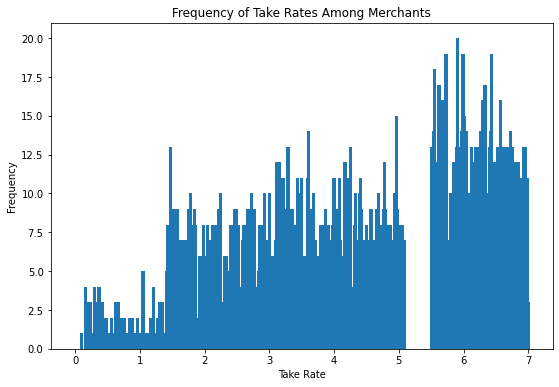

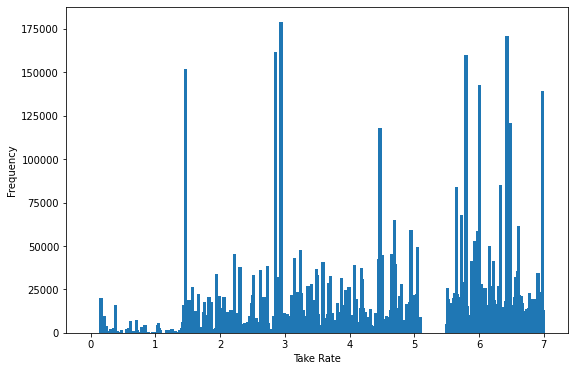

In [6]:
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = merchantdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')
plt.title('Frequency of Take Rates Among Merchants')


## Now do all transactions have valid take rates?
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = sdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')

There appears to be 3 distinct 'groups' in the distribution of take rate. The first comprising of very few merchants, which have a take rate between 0% and just over 1%. Rather logically, no merchants have a take rate of 0, and we don't see any nonsensical take rates either, such as negative take rates. 

The second group composes of merchants with a take take of just over 1% to roughly 5%. The number of merchants in this groups appears to have jumped significantly as compared to the previous group.

We notice a rather interesting pattern in that no merchants appear to have a take rate between just over 5% and roughly 5.5%. This could have something to do with the method used to determine take rate? Could make sense particularly with what appears to be 3 clear groups. 

The final group contains merchants between 5.5% take rate, and what appears to be the maximum possible take rate of 7%.

Finally, inside of each of the 3 groups, take rate appears to be uniformally distributed.

## Tags

In [7]:
merchantdf.groupby('tags').count().sort('tags').show(100, truncate=False)

# Now for transactions
sdf.groupby('tags').count().sort('tags').show(100, truncate=False)

+-------------------------------------------------------------------------------------+-----+
|tags                                                                                 |count|
+-------------------------------------------------------------------------------------+-----+
|antique shops - sales, repairs, and restoration services                             |129  |
|art dealers and galleries                                                            |112  |
|artist supply and craft shops                                                        |193  |
|bicycle shops - sales and service                                                    |170  |
|books, periodicals, and newspapers                                                   |164  |
|cable, satellite, and other pay television and radio services                        |175  |
|computer programming , data processing, and integrated systems design services       |191  |
|computers, computer peripheral equipment, and software     

+-------------------------------------------------------------------------------------+-------+
|tags                                                                                 |count  |
+-------------------------------------------------------------------------------------+-------+
|antique shops - sales, repairs, and restoration services                             |102617 |
|art dealers and galleries                                                            |12314  |
|artist supply and craft shops                                                        |270701 |
|bicycle shops - sales and service                                                    |128896 |
|books, periodicals, and newspapers                                                   |226658 |
|cable, satellite, and other pay television and radio services                        |550269 |
|computer programming , data processing, and integrated systems design services       |297667 |
|computers, computer peripheral equipmen

After cleaning up the field, there are actually only 25 different unique values for tags, with these being fairly evenly distributed amongst merchants. This is a fairly interesting finding, since it was at first thought that this field was unique to each vendor, particularly given its nature as being a field manually entered

The maximum count shows 195 merchants with tag 'digital goods: books, movies, music' and minimum count shows 91 merchants with tag 'jewelry, watch, clock and silverware shops'.

Viewing the occurences of these tags in transactions instead reveals certain tags are associated with more/less frequent transactions. For example, 'jewelry, watch, clock, and silverware shops' merchants are seen to have by far the least frequent amount of transaction as opposed to 'tent and awning shops' which have the most by far.

## Transactions

In [8]:
print(transactiondf.count() - sdf.count())

333642


By simply joining all tables to the transaction table via the relevant foreign keys, any transaction which can't be joined for some reason will be discarded. As seen above, this would mean that 333,642 transactions (as of the end of Week 2 data) would be simply discarded without our knowledge.

In [9]:
print(userdf.groupby('consumer_id').count().sort(desc('count')))
print(userdf.groupby('consumer_id').count().sort(desc('count')).count())
print(userdf.groupby('user_id').count().sort(desc('count')))
print(userdf.groupby('user_id').count().sort(desc('count')).count())
print(transactiondf.groupby('user_id').count().sort('user_id').count())
print(transactiondf.groupby('user_id').count().sort('count'))

+-----------+-----+
|consumer_id|count|
+-----------+-----+
|     367113|    1|
|    1255411|    1|
|     999838|    1|
|    1406677|    1|
|     331653|    1|
|     105297|    1|
|     893193|    1|
|    1093060|    1|
|     147768|    1|
|     194306|    1|
|    1402299|    1|
|     393166|    1|
|    1471150|    1|
|     615626|    1|
|      78271|    1|
|     467704|    1|
|     832715|    1|
|     168801|    1|
|      61300|    1|
|    1253794|    1|
+-----------+-----+
only showing top 20 rows



499999


+-------+-----+
|user_id|count|
+-------+-----+
|     41|    1|
|    499|    1|
|    907|    1|
|   1085|    1|
|   1114|    1|
|   1273|    1|
|   1473|    1|
|   1574|    1|
|   1689|    1|
|   1695|    1|
|   1716|    1|
|   1783|    1|
|   2051|    1|
|   2171|    1|
|   2474|    1|
|   2556|    1|
|   2825|    1|
|   2935|    1|
|   3017|    1|
|   3108|    1|
+-------+-----+
only showing top 20 rows

499999


24081


+-------+-----+
|user_id|count|
+-------+-----+
|  11982|  285|
|  22367|  286|
|   8755|  289|
|   4760|  290|
|   2713|  291|
|   4794|  292|
|  23378|  292|
|  21598|  292|
|  17995|  294|
|   9026|  294|
|   5989|  295|
|   6183|  295|
|   2150|  296|
|   1510|  296|
|  13052|  296|
|  16332|  296|
|   8905|  296|
|  20629|  297|
|  12950|  297|
|  13951|  297|
+-------+-----+
only showing top 20 rows



There are no problems caused by joining this table (apart from the strange inclusion of a surrogate key). This table simply maps all user_ids from 0-499999 to some consumer_id. However, in the data given only user_ids up to 24,081 actually have at least 1 valid transaction in the dataset, meaning many of these mappings appear to go unused.

In [10]:
dropped_transactions = transactiondf.join(sdf, 'order_id', "leftanti")
dropped_transactions.count()

333642

In [11]:
dropped_transactions

order_id,user_id,merchant_abn,dollar_value,order_datetime
00010154-c8c6-492...,14132,43820812476,145.7508223047609,2021-04-03
0001f004-f3b9-479...,9553,48540087213,2535.012136880364,2021-03-24
000334fe-7ab8-4e7...,2438,11240426404,161.65965550330247,2021-05-01
000a5afb-4c3b-458...,14983,33604812025,174.06729685924134,2021-05-01
000c6979-a96c-468...,1221,29323795999,0.583128432753908,2021-08-15
0012083d-3d78-4a6...,21522,73121558118,76.2031996487711,2021-04-30
0016c89c-7e71-4c2...,9410,95492562735,30.124085051663126,2021-05-24
0017b5e7-2cf3-494...,2088,87802246756,184.15325198043612,2021-06-21
001dab75-e07a-425...,7020,32234779638,177.6279422305109,2021-04-23
00230efc-c131-498...,20787,63966446164,172.42893653118102,2021-04-22


In [12]:
print(dropped_transactions.filter(dropped_transactions.user_id > 24081))

+--------+-------+------------+------------+--------------+
|order_id|user_id|merchant_abn|dollar_value|order_datetime|
+--------+-------+------------+------------+--------------+
+--------+-------+------------+------------+--------------+



No transactions were dropped due to not having a valid user id.

In [13]:
print(dropped_transactions.groupby('merchant_abn').count().count())
print(dropped_transactions.groupby('merchant_abn').count().sort('merchant_abn'))
print(dropped_transactions.join(merchantdf, "merchant_abn"))

395


+------------+-----+
|merchant_abn|count|
+------------+-----+
| 10672322914|   64|
| 11029341140|   11|
| 11137507330| 1159|
| 11240426404|31216|
| 11358147682|   50|
| 11400713351|   35|
| 11839682616|  431|
| 12959561070|    1|
| 13129485817|    6|
| 13177076095|  185|
| 13226823813|  328|
| 13289167958|    7|
| 13494073581|   15|
| 13868849576|  469|
| 14827550074|  830|
| 15058508937|   23|
| 15073921424|   10|
| 15699401518|  142|
| 15862090061|  144|
| 16496390781|   44|
+------------+-----+
only showing top 20 rows



+------------+--------+-------+------------+--------------+------------+----+---------+------------+
|merchant_abn|order_id|user_id|dollar_value|order_datetime|company_name|tags|take_rate|revenue_band|
+------------+--------+-------+------------+--------------+------------+----+---------+------------+
+------------+--------+-------+------------+--------------+------------+----+---------+------------+



Therefore, all invalid transactions are shown to be dropped because they do not have a valid merchant_abn to link to. Maybe one might want to consider all these merchants as if they shared the same tag, however removing them would also seem sensible.

## Merchants

In [14]:
no_transaction_merchants = merchantdf.join(sdf.groupby('merchant_abn').count(), 'merchant_abn', "leftanti")
no_transaction_merchants

merchant_abn,company_name,tags,take_rate,revenue_band
76866488151,Euismod Urna Company,antique shops - s...,4.08,b
46537010521,Tempor Augue Ac C...,"jewelry, watch, c...",2.18,c
55555661470,Nullam Scelerisqu...,"jewelry, watch, c...",1.83,c
28311306642,Egestas Nunc Sed LLC,antique shops - s...,4.93,b
47047735645,Aenean Gravida In...,antique shops - s...,1.54,c
55403018592,Elit Limited,antique shops - s...,4.84,b
93267734067,Curae Foundation,"jewelry, watch, c...",2.57,c


There are therefore 7 merchants in the merchant dataframe that do not have a single transaction present in the transactional database as of yet. Of interest is their shared tags, only being either antique shops or jewelry etc. stores. We don't really have to remove these per say, they will exist in case any future transactions released have transactions of these merchants. 